# Artificial Neural Network (ANN)

This notebook explores the effectiveness of a simple feedforward Artificial Neural Network (ANN) for solving a binary classification problem: predicting whether a customer will churn (leave a service) based on historical data from a retail bank.

## Importing Libraries

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Deep learning
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import AUC

## Data Loading and Exploration

In [2]:
# Load the dataset
df = pd.read_csv("./data/Churn_Modelling.csv")
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [3]:
# Basic info about datatypes and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
# Check for missing values
print("\nMissing values per column:")
df.isnull().sum()


Missing values per column:


RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
# Basic statistics
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


The mean of **Exited** is 0.2037, indicating that only about **20%** of customers in the dataset have churned. This highlights a significant **class imbalance**.

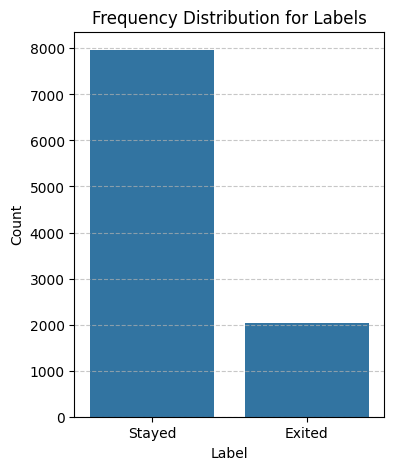

In [6]:
# Plot Class distribution
plt.figure(figsize=(4,5))
sns.countplot(x='Exited', data=df)

plt.xticks([0, 1], ['Stayed', 'Exited'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Frequency Distribution for Labels')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Data Cleaning & Preprocessing

In [7]:
# Drop irrelevant columns
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

# Encode categorical variables
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True, dtype=int)
df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,1


In [19]:
# Define features and target
X = df.drop('Exited', axis=1)
y = df['Exited']

# Preserve target class distribution in train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Compute class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Class Weights:", class_weights)

# Define early stopping callback to monitor validation loss
early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=10,              
    restore_best_weights=True, 
    verbose=1
)

Class Weights: {0: 0.6279434850863422, 1: 2.4539877300613497}


## ANN Model: Training and Evaluation

In [20]:
# Build the ANN model
model = Sequential([
    Dense(16, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[AUC(name='auc')])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stopping], 
    verbose=1
)

Epoch 1/100
200/200 [==============================] - 1s 5ms/step - loss: 0.6862 - auc: 0.5687 - val_loss: 0.6575 - val_auc: 0.7066
Epoch 2/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6490 - auc: 0.6695 - val_loss: 0.6068 - val_auc: 0.7524
Epoch 3/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6245 - auc: 0.7148 - val_loss: 0.5932 - val_auc: 0.7658
Epoch 4/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6114 - auc: 0.7282 - val_loss: 0.5707 - val_auc: 0.7747
Epoch 5/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5972 - auc: 0.7520 - val_loss: 0.5761 - val_auc: 0.7812
Epoch 6/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5909 - auc: 0.7595 - val_loss: 0.5560 - val_auc: 0.7857
Epoch 7/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5834 - auc: 0.7658 - val_loss: 0.5358 - val_auc: 0.7882
Epoch 8/100
200/200 [==============================] - 1s 3ms/step - 

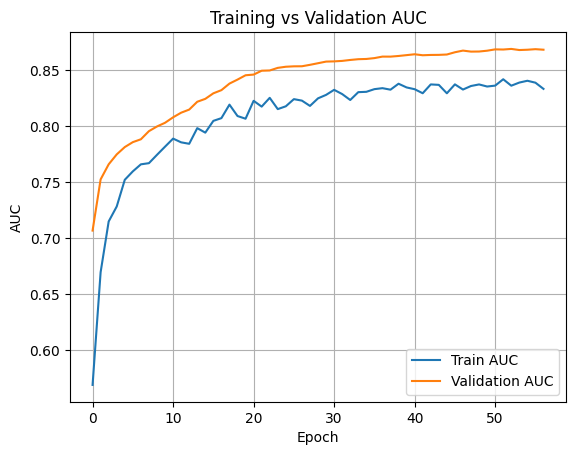

In [21]:
# Plot training and validation AUC over epochs to monitor overfitting
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.title("Training vs Validation AUC")
plt.show()

In [22]:
# Evaluate model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

63/63 [==============================] - 0s 962us/step



Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1593
           1       0.51      0.74      0.61       407

    accuracy                           0.80      2000
   macro avg       0.72      0.78      0.74      2000
weighted avg       0.84      0.80      0.82      2000



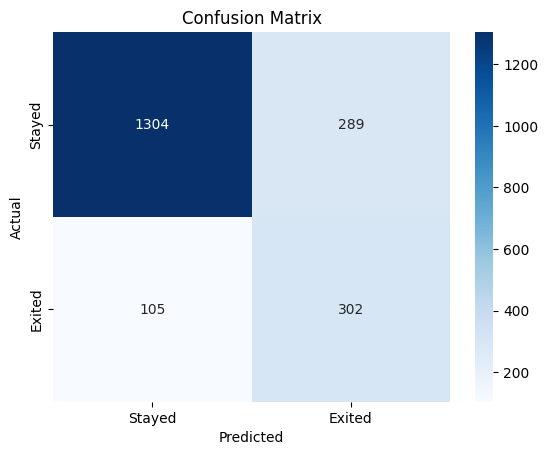

In [23]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Stayed", "Exited"], yticklabels=["Stayed", "Exited"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

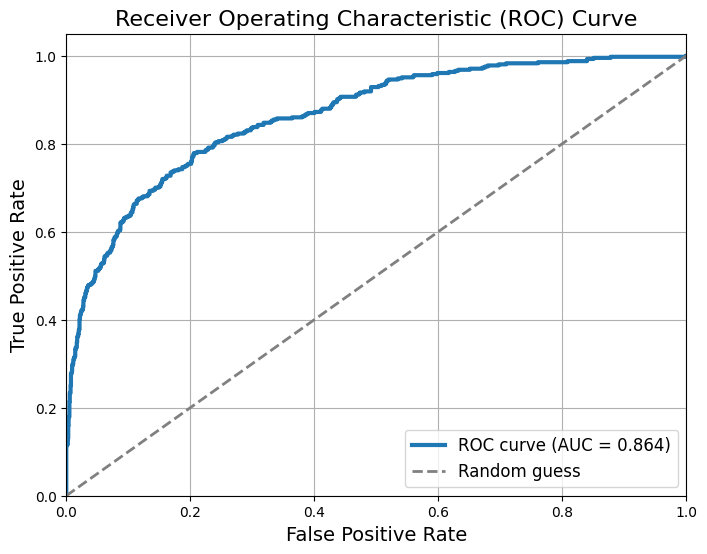

In [24]:
# Compute ROC curve metrics and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve with AUC and random guess baseline
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, lw=3, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random guess')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.show()

## Conclusion

This notebook demonstrates the effectiveness of a simple feedforward Artificial Neural Network (ANN) in predicting customer churn based on bank customer data.

- **Accuracy**: 80% on the test set  
- **AUC**: 0.864, indicating strong overall classification performance  
- **Recall (Churn class)**: 74%, the model captures most of the actual churners  
- **Precision (Non-churn class)**: 93%, high confidence when predicting customers who will stay

While the model was affected by class imbalance, with lower precision for churners, using **class weights** and **stratified splitting** helped boost recall for the minority class.